# Final Capstone: Revisiting the Netflix Prize
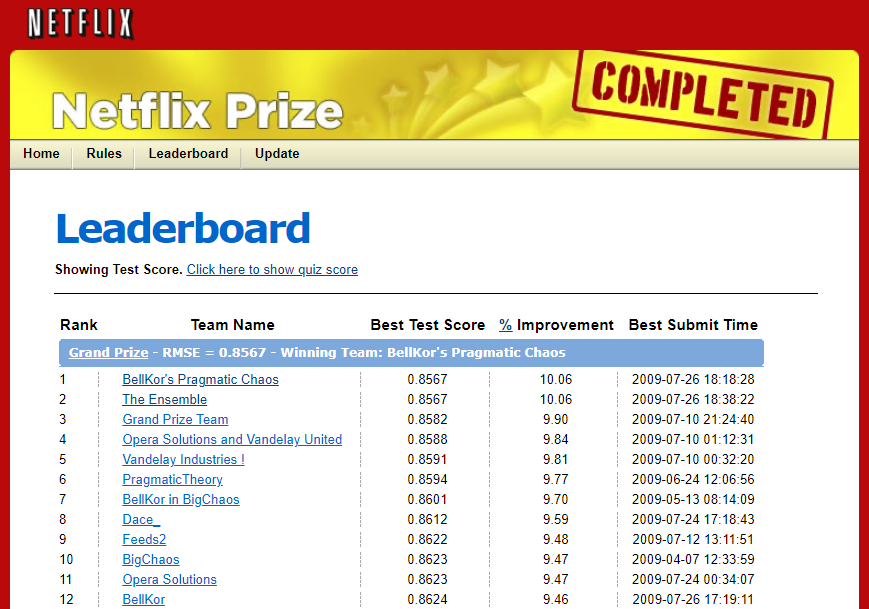

## Notebook 1: Overview and DataFrame Manipulation

In [1]:
import os
import time
from datetime import datetime
start_time = time.perf_counter()
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
base_path = 'C:/Users/jnpol/Documents/DS/Data Science/UL/'

def merge_files(file_list, csv_file):
    if not os.path.isfile(base_path + csv_file):
        data = open(csv_file, mode='w')
        row = list()
        files = file_list
        
        for file in files:
            print('Reading from {}...'.format(file))
            with open(file) as f:
                for line in f:
                    del row[:]
                    line = line.strip()
                    if line.endswith(':'):
                        movie_id = line.replace(':', '')
                    else:
                        row = [x for x in line.split(',')]
                        row.insert(0, movie_id)
                        data.write(','.join(row))
                        data.write('\n')
            print('Done.\n')
        data.close()
        
probe_path = [base_path + 'probe.txt']
data_path = [base_path + 'data_1_1-4499.txt',
             base_path + 'data_2_4500-9210.txt',
             base_path + 'data_3_9211-13367.txt',
             base_path + 'data_4_13368-17770.txt']
merge_files(probe_path, 'probe.csv')
merge_files(data_path, 'data.csv')

In [3]:
%%time
# import movie titles data set, and netflix training and quiz sets
movs = pd.read_csv(base_path + 'mov_titles.csv', encoding='latin1')
quiz = pd.read_csv(base_path + 'probe.csv', header=None,
                   names=['mov_id', 'cust_id'])
net = pd.read_csv(base_path + 'data.csv', header=None,
                   names=['mov_id', 'cust_id', 'rating', 'date'])
movs.info()
display(movs.head())
print()
quiz.info()
display(quiz.head())
print()
net.info()
print()
net.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mov_id     17770 non-null  int64 
 1   mov_year   17770 non-null  int64 
 2   mov_title  17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB


,mov_id,mov_year,mov_title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408395 entries, 0 to 1408394
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   mov_id   1408395 non-null  int64
 1   cust_id  1408395 non-null  int64
dtypes: int64(2)
memory usage: 21.5 MB


,mov_id,cust_id
0,1,30878
1,1,2647871
2,1,1283744
3,1,2488120
4,1,317050



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   mov_id   int64 
 1   cust_id  int64 
 2   rating   int64 
 3   date     object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB

Wall time: 24.5 s


,mov_id,cust_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [4]:
%%time
# drop movie titles and manage memory usage via dtypes
movs.drop(['mov_title'], 1, inplace=True)
movs.mov_id = movs.mov_id.astype(np.int16)
movs.mov_year = movs.mov_year.astype(np.int16)
quiz.mov_id = quiz.mov_id.astype(np.int16)
quiz.cust_id = quiz.cust_id.astype(np.int32)
net.mov_id = net.mov_id.astype(np.int16)
net.cust_id = net.cust_id.astype(np.int32)
net.rating = net.rating.astype(np.int8)

Wall time: 1.08 s


In [5]:
%%time
# convert to datetime; extract year, month, and day; manage memory
net.date = pd.to_datetime(net.date)
net['rate_year'] = pd.DatetimeIndex(net.date).year
net.rate_year = net.rate_year.astype(np.int16)
net['adj_year'] = net.rate_year - net.rate_year.min()
net.adj_year = net.adj_year.astype(np.int8)
net['rate_month'] = pd.DatetimeIndex(net.date).month
net.rate_month = net.rate_month.astype(np.int8)
net['rate_day'] = pd.DatetimeIndex(net.date).day
net.rate_day = net.rate_day.astype(np.int8)
net.drop(['date'], 1, inplace=True)
net.info()
print()
display(net.head())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 7 columns):
 #   Column      Dtype
---  ------      -----
 0   mov_id      int16
 1   cust_id     int32
 2   rating      int8 
 3   rate_year   int16
 4   adj_year    int8 
 5   rate_month  int8 
 6   rate_day    int8 
dtypes: int16(2), int32(1), int8(4)
memory usage: 1.1 GB



,mov_id,cust_id,rating,rate_year,adj_year,rate_month,rate_day
0,1,1488844,3,2005,6,9,6
1,1,822109,5,2005,6,5,13
2,1,885013,4,2005,6,10,19
3,1,30878,4,2005,6,12,26
4,1,823519,3,2004,5,5,3



Wall time: 23.1 s


In [6]:
%%time
# convert years to days; a day for each leap year
def ytd(zeroed_series, orig_series):
    zeroed_list = list(zeroed_series)
    orig_list = list(orig_series)
    ytd_list = []
    i = 0
    for yr in zeroed_list:
        x = 365 * yr
        if orig_list[i] % 4 == 0:
            x += 1
        else:
            pass
        ytd_list.append(x)
        i += 1
    return ytd_list

# add return value to df; manage memory
net['ytd'] = ytd(net.adj_year, net.rate_year)
net.ytd = net.ytd.astype(np.int16)
net.drop(['adj_year'], 1, inplace=True)

Wall time: 55.8 s


In [7]:
%%time
# calculate number of days in each month
def mtd(month_series, year_series):
    mo_list = list(month_series)
    year_list = list(year_series)
    mtd_list = []
    i = 0
    for mo in mo_list:
        x = 0
        if mo > 1:
            x = 31
        if mo > 2:
            if year_list[i] % 4 == 0:
                x += 29
            else:
                x += 28
        if mo > 3:
            x += 31
        if mo > 4:
            x += 30
        if mo > 5:
            x += 31
        if mo > 6:
            x += 30
        if mo > 7:
            x += 31
        if mo > 8:
            x += 31
        if mo > 9:
            x += 30
        if mo > 10:
            x += 31
        if mo > 11:
            x += 30
        mtd_list.append(x)
        i += 1
    return mtd_list

# add return value to df; manage memory
net['mtd'] = mtd(net.rate_month, net.rate_year)
net.mtd = net.mtd.astype(np.int16)
net.drop(['rate_month', 'rate_year'], 1, inplace=True)

Wall time: 1min 14s


In [8]:
%%time
# add days; reset min value to day 1; manage memory
net['day_rated'] = net.ytd + net.mtd + net.rate_day
net.day_rated = net.day_rated - net.day_rated.min() + 1
net.day_rated = net.day_rated.astype(np.int16)
net.drop(['rate_day', 'mtd', 'ytd'], 1, inplace=True)

Wall time: 2.27 s


In [9]:
%%time
# merge dataframes to add mov_year (release year)
net = net.merge(movs, how='right', on='mov_id')
net.info()
net.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 0 to 100480506
Data columns (total 5 columns):
 #   Column     Dtype
---  ------     -----
 0   mov_id     int16
 1   cust_id    int32
 2   rating     int8 
 3   day_rated  int16
 4   mov_year   int16
dtypes: int16(3), int32(1), int8(1)
memory usage: 1.8 GB
Wall time: 8.15 s


,mov_id,cust_id,rating,day_rated,mov_year
0,1,1488844,3,2125,2003
1,1,822109,5,2009,2003
2,1,885013,4,2168,2003
3,1,30878,4,2236,2003
4,1,823519,3,1636,2003


In [10]:
%%time
# merge dataframes to get ratings for quiz set
quiz = net.merge(quiz, on=['mov_id', 'cust_id'], right_index=True)
quiz.info()
quiz.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1408395 entries, 3 to 100480411
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   mov_id     1408395 non-null  int16
 1   cust_id    1408395 non-null  int32
 2   rating     1408395 non-null  int8 
 3   day_rated  1408395 non-null  int16
 4   mov_year   1408395 non-null  int16
dtypes: int16(3), int32(1), int8(1)
memory usage: 25.5 MB
Wall time: 29.4 s


,mov_id,cust_id,rating,day_rated,mov_year
3,1,30878,4,2236,2003
47,1,2647871,4,2240,2003
59,1,1283744,3,1620,2003
79,1,2488120,5,2139,2003
135,1,317050,5,2195,2003


In [11]:
%%time
# copy and set aside all_ratings
all_ratings = net.drop(['mov_id', 'cust_id', 'day_rated', 'mov_year'], 1)

Wall time: 498 ms


In [12]:
%%time
# pass quiz index to drop corresponding rows in training set
quiz_idx = list(quiz.index)
net.drop(quiz_idx, inplace=True)
net.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99072112 entries, 0 to 100480506
Data columns (total 5 columns):
 #   Column     Dtype
---  ------     -----
 0   mov_id     int16
 1   cust_id    int32
 2   rating     int8 
 3   day_rated  int16
 4   mov_year   int16
dtypes: int16(3), int32(1), int8(1)
memory usage: 1.8 GB
Wall time: 13.5 s


In [13]:
%%time
# drop ratings from the quiz set; concatenate dfs, then sort net df
quiz.drop(['rating'], 1, inplace=True)
net = pd.concat([net, quiz])
net.sort_index(inplace=True)
net.info()
display(net.isna().sum())
net.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 0 to 100480506
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   mov_id     int16  
 1   cust_id    int32  
 2   rating     float64
 3   day_rated  int16  
 4   mov_year   int16  
dtypes: float64(1), int16(3), int32(1)
memory usage: 2.4 GB


mov_id             0
cust_id            0
rating       1408395
day_rated          0
mov_year           0
dtype: int64

Wall time: 8.38 s


,mov_id,cust_id,rating,day_rated,mov_year
0,1,1488844,3.00,2125,2003
1,1,822109,5.00,2009,2003
2,1,885013,4.00,2168,2003
3,1,30878,nan,2236,2003
4,1,823519,3.00,1636,2003


In [14]:
%%time
quindex = pd.DataFrame(quiz_idx, columns=['quindex'])
quindex.to_parquet('quindex.parquet')
all_ratings.to_parquet('all_ratings.parquet')
net.to_parquet('net1.parquet')

Wall time: 10.9 s
